<a href="https://colab.research.google.com/github/natalfr17/Projeto-Aplicado-III/blob/main/tarefa_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Análise de Regressão Linear - Ames Housing Dataset

Será realizada uma análise estatística utilizando regressão linear para prever o preço de venda de imóveis. A análise seguirá os seguintes passos:

- Análise exploratória dos dados;
- Modelagem com regressão linear múltipla;
- Avaliação dos pressupostos do modelo;
- Interpretação dos coeficientes;
- Análise de interação entre variáveis;
- Avaliação de desempenho e possíveis melhorias no modelo.

O dataset está disponível no Kaggle e contém 2930 observações e 82 variáveis.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("prevek18/ames-housing-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ames-housing-dataset


In [ ]:
# Importar principais bibliotecas
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from scipy import stats
from scipy import optimize
from statsmodels.compat import lzip
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import mannwhitneyu
from sklearn.linear_model import LinearRegression

# Carregar a base
df = pd.read_csv('/kaggle/input/ames-housing-dataset/AmesHousing.csv')
display(df.head())

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


## Análise Exploratória

Nesta etapa, será verificada a estrutura dos dados e valores ausentes, além disso, será realizada uma análise de correlação entre as variáveis numéricas.

In [ ]:
# Identificar variáveis numéricas e categóricas

numeric_cols = df.select_dtypes(include=["number"]).columns
categorical_cols = df.select_dtypes(include=["object"]).columns

print("\n-------- Feature Type Summary --------")
print(f"Total features:      {df.shape[1]}")
print(f"Numerical features:  {len(numeric_cols)}")
print(f"Categorical features:{len(categorical_cols)}")
print("\nSample numeric cols:", list(numeric_cols[:10]))
print("Sample categorical cols:", list(categorical_cols[:10]))


-------- Feature Type Summary --------
Total features:      82
Numerical features:  39
Categorical features:43

Sample numeric cols: ['Order', 'PID', 'MS SubClass', 'Lot Frontage', 'Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area']
Sample categorical cols: ['MS Zoning', 'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1']


In [ ]:
# Contagem de valores Nulos, listando os mais expressivos
df.isna().sum().sort_values(ascending=False)[df.isna().sum() > 100]

,0
Pool QC,2917
Misc Feature,2824
Alley,2732
Fence,2358
Mas Vnr Type,1775
Fireplace Qu,1422
Lot Frontage,490
Garage Qual,159
Garage Yr Blt,159
Garage Cond,159


In [ ]:
# Remover colunas com muitos dados ausentes (>25%)
missing = df.isna().sum() / len(df)
df = df.drop(columns=missing[missing > 0.25].index)


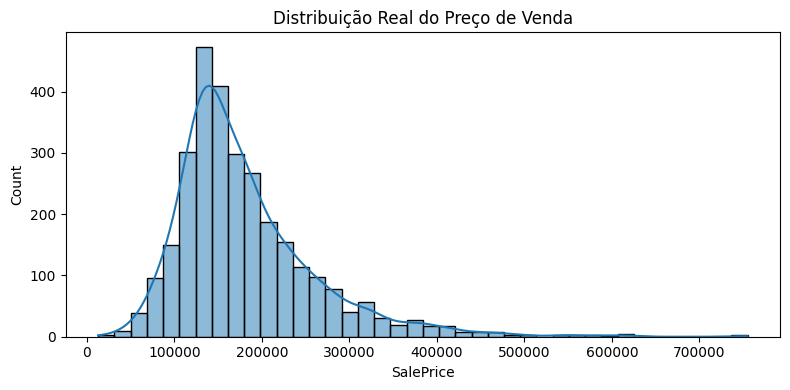

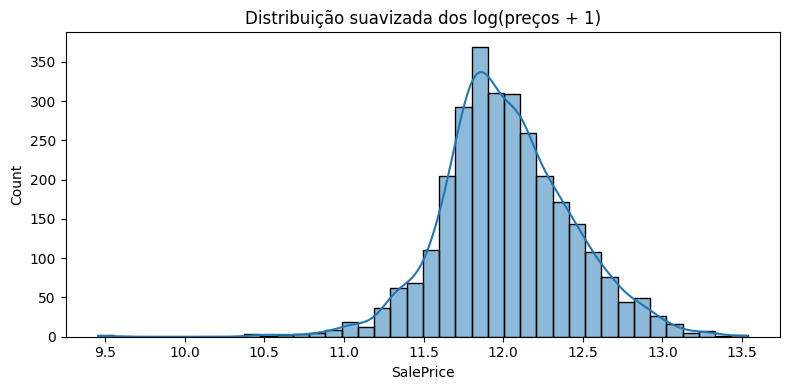

In [ ]:
# Distribuição do Preço de Venda

plt.figure(figsize=(8, 4))
sns.histplot(df["SalePrice"], bins=40, kde=True)
plt.title("Distribuição Real do Preço de Venda")
plt.tight_layout()
plt.show()

# Distribuição do log do Preço de Venda (log1p) para reduzir a assimetria e aproximar da normalidade

plt.figure(figsize=(8, 4))
sns.histplot(np.log1p(df["SalePrice"]), bins=40, kde=True)
plt.title("Distribuição suavizada dos log(preços + 1)")
plt.tight_layout()
plt.show()

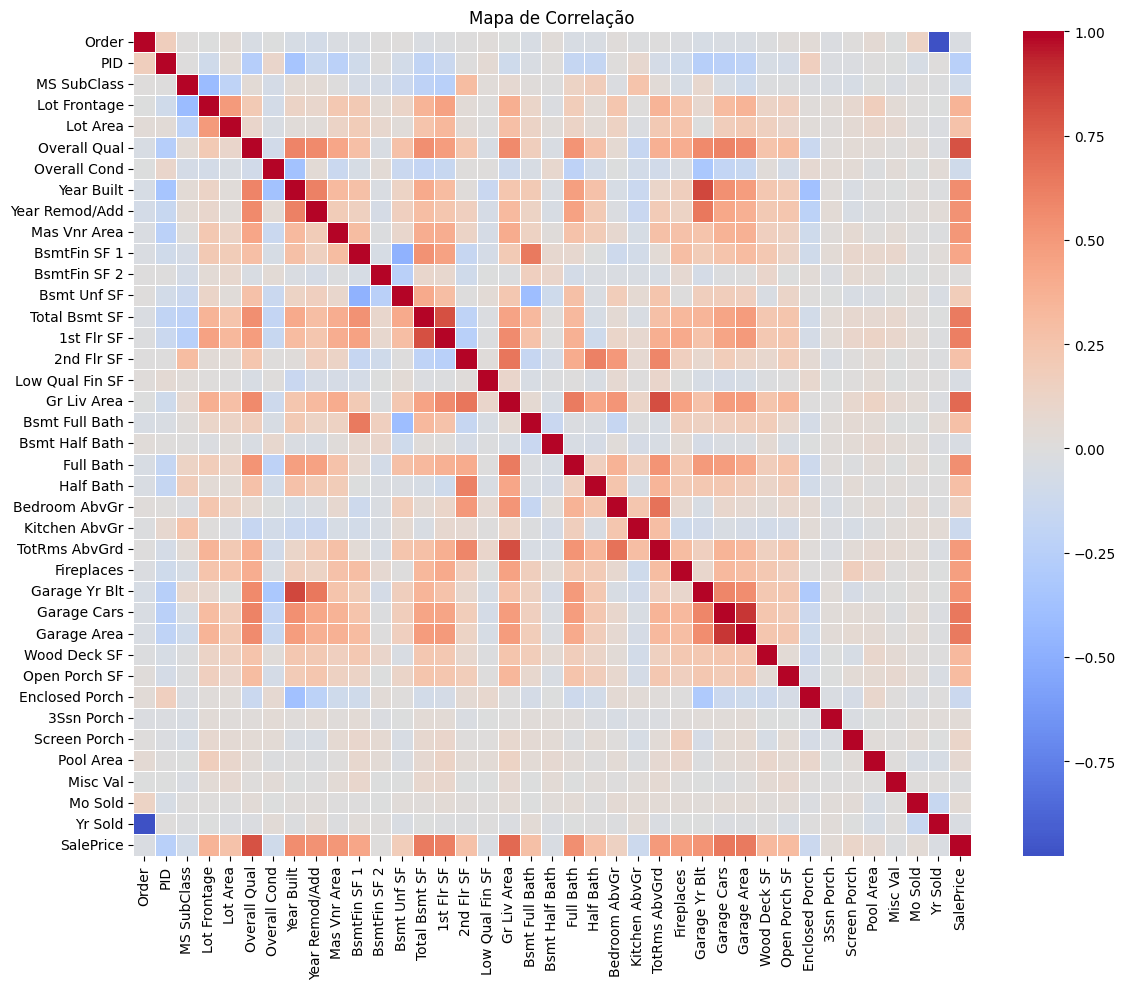

In [ ]:
# Analise de Correlação das variáveis numéricas

# Matriz de correlação
corr = df[numeric_cols].corr()
# Heatmap (mapa de calor) da correlação
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="coolwarm", center=0, linewidths=0.4)
plt.title("Mapa de Correlação")
plt.tight_layout()
plt.show()

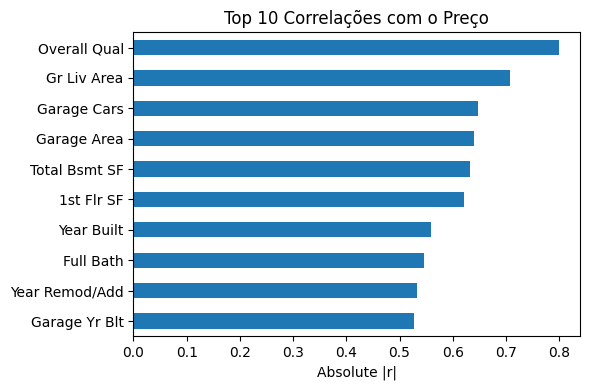

In [ ]:
# Seleção das 10 variáveis mais correlacionadas com SalePrice
top_corr = (corr["SalePrice"].drop("SalePrice").abs().sort_values(ascending=False).head(10))

# Gráfico de barras com as top 10 correlações
plt.figure(figsize=(6, 4))
top_corr.plot(kind="barh")
plt.title("Top 10 Correlações com o Preço")
plt.xlabel("Absolute |r|")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

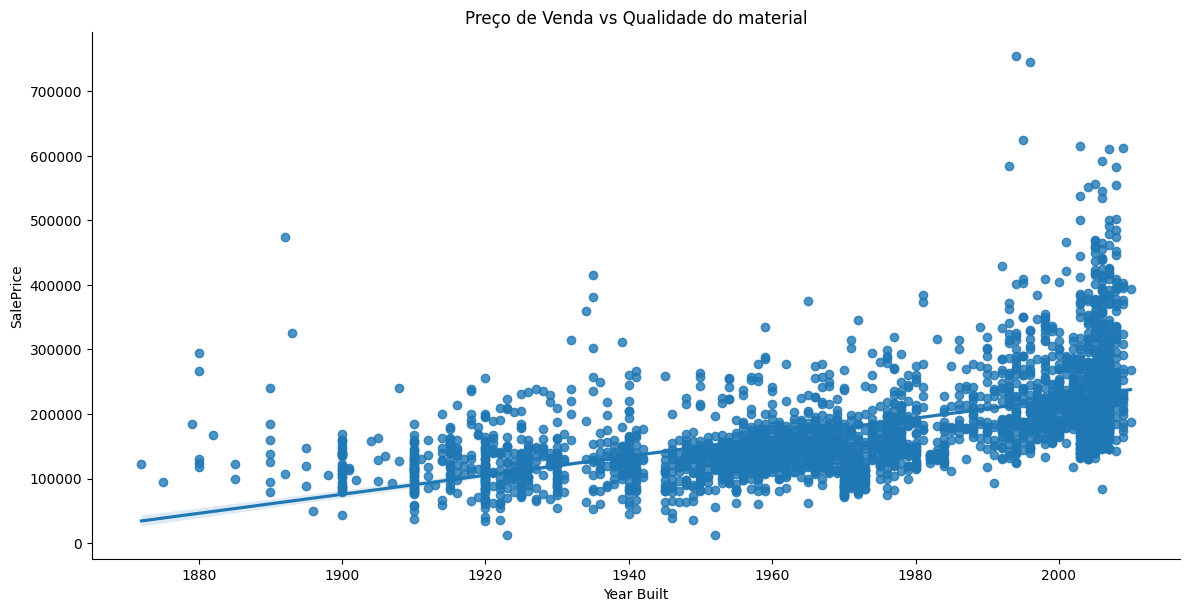

In [23]:
# Foram escolhidas as 3 variáveis numéricas dentre as listadas com maior correlação

# Analisar visualmente relações lineares entre duas variáveis

sns.lmplot(x='Year Built', y='SalePrice', data=df, aspect=2, height=6)
plt.title('Preço de Venda vs Qualidade do material')
plt.show()

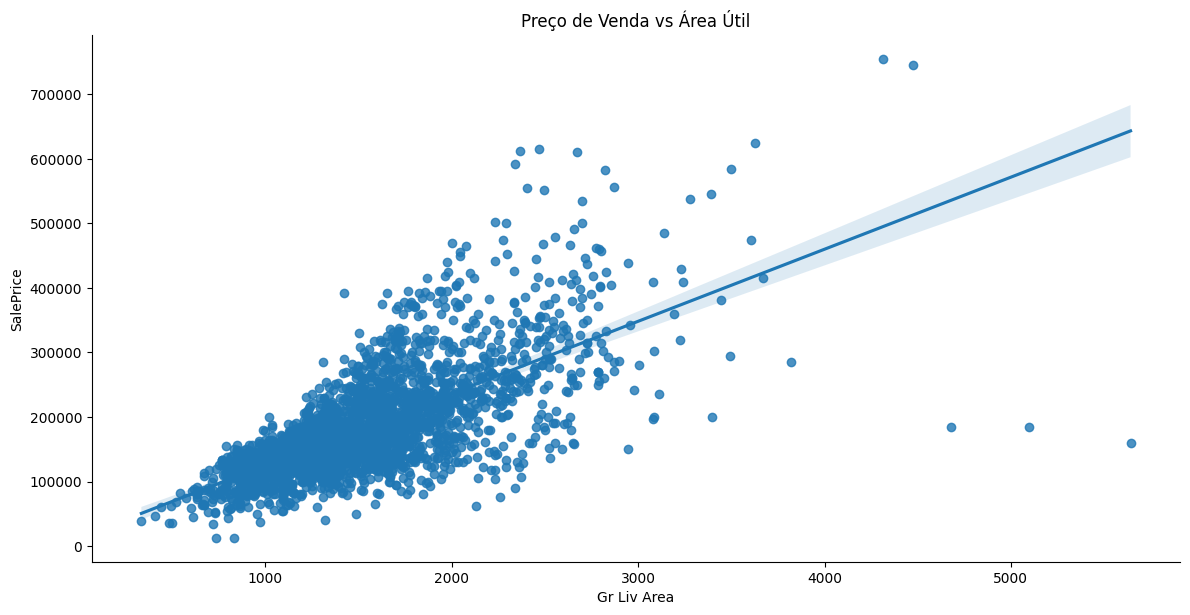

In [22]:
sns.lmplot(x='Gr Liv Area', y='SalePrice', data=df, aspect=2, height=6)
plt.title('Preço de Venda vs Área Útil')
plt.show()

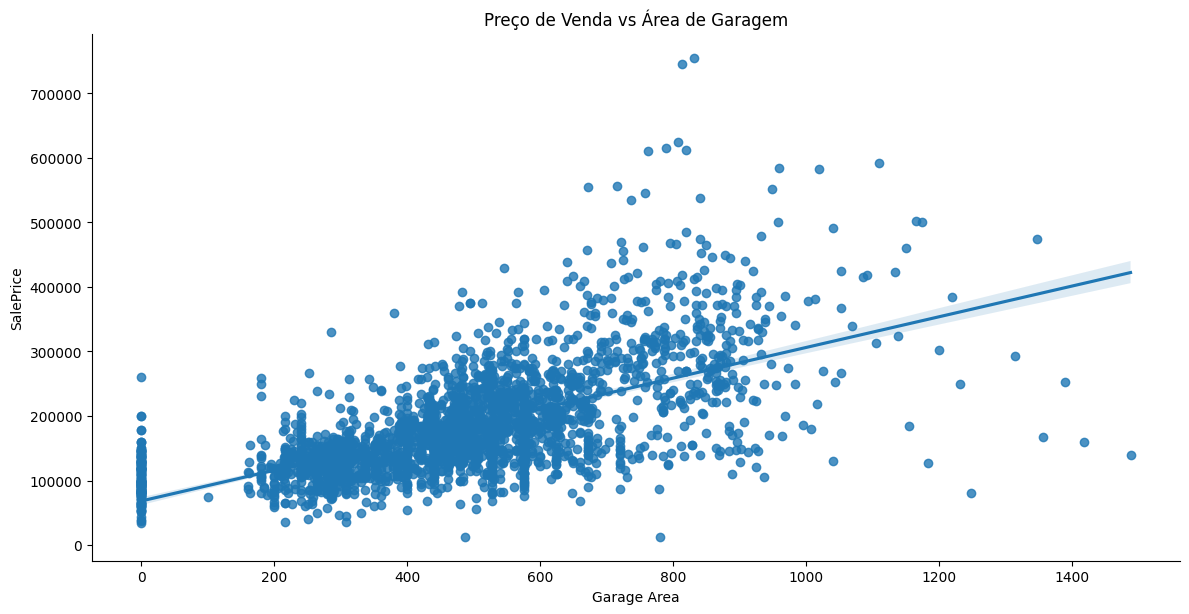

In [24]:
sns.lmplot(x='Garage Area', y='SalePrice', data=df, aspect=2, height=6)
plt.title('Preço de Venda vs Área de Garagem')
plt.show()

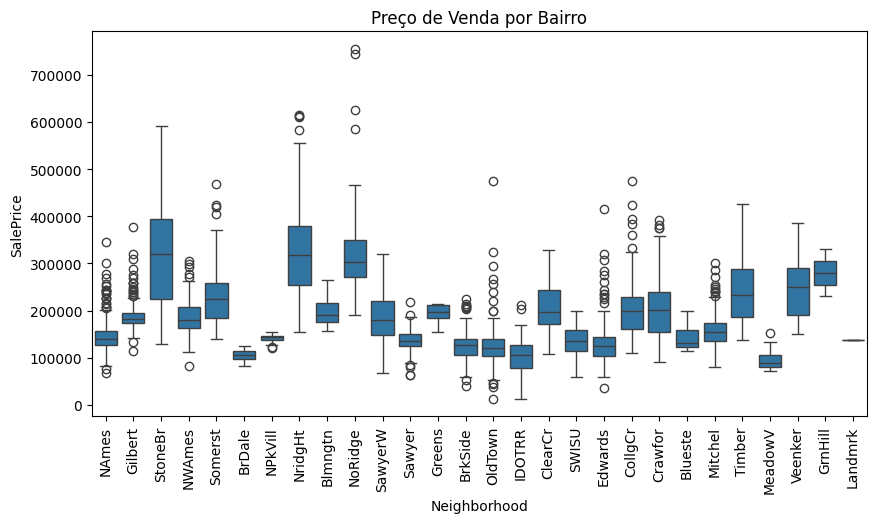

In [ ]:
# Relação entre as variáveis Neighborhood (categórica) vs SalePrice
plt.figure(figsize=(10,5))
sns.boxplot(x='Neighborhood', y='SalePrice', data=df)
plt.xticks(rotation=90)
plt.title("Preço de Venda por Bairro")
plt.show()

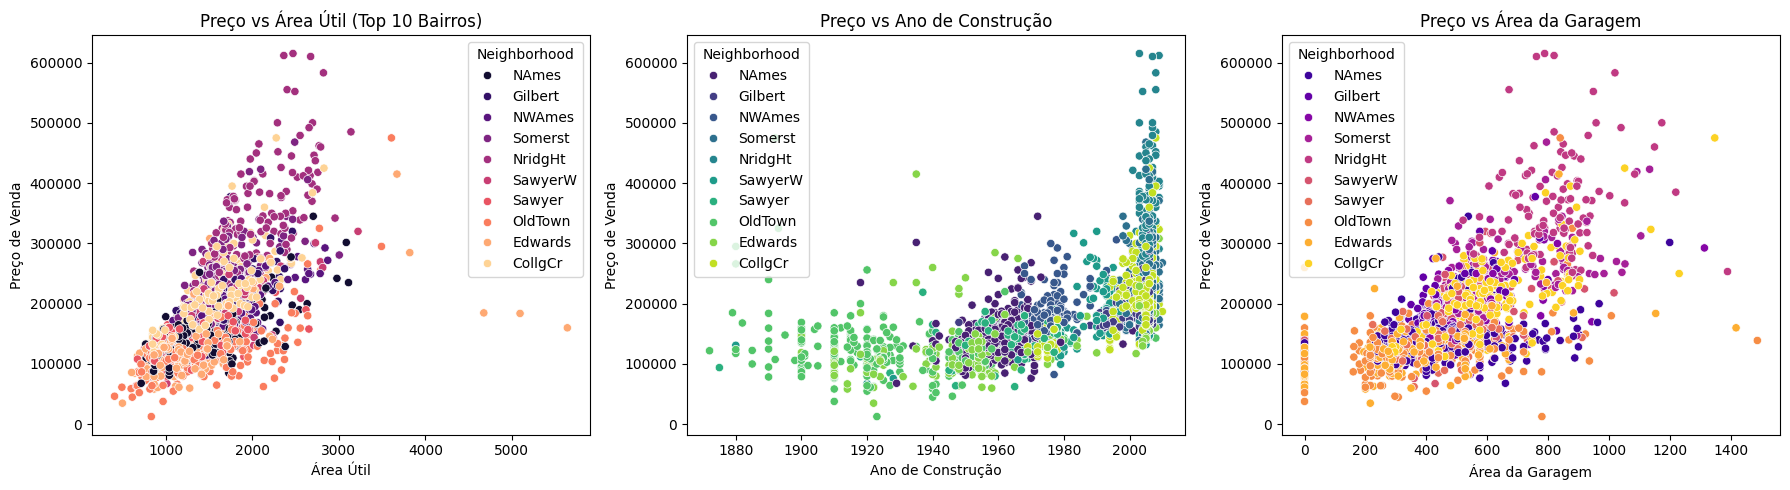

In [ ]:
# Visualizar a relação entre duas variáveis numéricas, e a influência de uma variável categórica

# Identificar os 10 bairros mais frequentes
top_10_neighborhoods = df['Neighborhood'].value_counts().nlargest(10).index

# Filtrar o DataFrame para incluir apenas os 10 bairros mais frequentes
df_filtered = df[df['Neighborhood'].isin(top_10_neighborhoods)]

# Visualizar a relação entre duas variáveis numéricas, e a influência de uma variável categórica
# Criar figura com 3 subplots lado a lado
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Gráfico 1: Área Útil vs Preço
sns.scatterplot(x='Gr Liv Area', y='SalePrice', data=df_filtered, hue='Neighborhood', palette='magma', ax=ax1)
ax1.set_title('Preço vs Área Útil (Top 10 Bairros)')
ax1.set_xlabel('Área Útil')
ax1.set_ylabel('Preço de Venda')

# Gráfico 2: Ano de Construção vs Preço
sns.scatterplot(x='Year Built', y='SalePrice', data=df_filtered, hue='Neighborhood', palette='viridis', ax=ax2)
ax2.set_title('Preço vs Ano de Construção')
ax2.set_xlabel('Ano de Construção')
ax2.set_ylabel('Preço de Venda')

# Gráfico 3: Área da Garagem vs Preço
sns.scatterplot(x='Garage Area', y='SalePrice', data=df_filtered, hue='Neighborhood', palette='plasma', ax=ax3)
ax3.set_title('Preço vs Área da Garagem')
ax3.set_xlabel('Área da Garagem')
ax3.set_ylabel('Preço de Venda')

plt.tight_layout()
plt.show()

OBS: As três variáveis escolhidas têm fundamentação estatística e negocial:
- `Gr Liv Area` apresenta relação linear positiva e tamanho de área construída, do ponto de vista negocial, tende a interferir no valor de venda do imóvel.
- `Year Built` mostra aumento recente nos preços, embora com variação alta. Também pode ter impacto negocial expressivo no valor do imóvel, considerando que costumam ter baixa necessidade de reformas ou de manutenção além de poderem contar com uma arquitetura mais moderna e estrutura tecnológica.
- `Garage Area` também apresentou uma relação linear positiva e pode ser um atrativo negocial, especialmente em áreas com menor cobertura de transporte público ou em famílias maiores que necessitam ter mais de um carro.
- `Neighborhood` demonstra diferenças marcantes no preço entre os bairros, sendo essencial como controle locacional.


## Modelo de Regressão Linear

- Variáveis numéricas: Gr Liv Area, Year Built, Garage Area
- Variável categórica: `Neighborhood`, transformada via dummies.
"""


In [ ]:
# Selecionar variáveis
X = df[['Gr Liv Area', 'Year Built', 'Garage Area', 'Neighborhood']]
y = df['SalePrice']

# Transformar Neighborhood em dummies e garantir tipo numérico
dummies = pd.get_dummies(X['Neighborhood'], drop_first=True).astype(float)

# Combinar numéricas com dummies
X_model = pd.concat([X[['Gr Liv Area', 'Year Built', 'Garage Area']], dummies], axis=1)

# Adicionar constante
X_model_constant = sm.add_constant(X_model).astype(float)

# Ajustar modelo
modelo = sm.OLS(y, X_model_constant, missing='drop').fit()

# Fazendo previsões com o modelo ajustado
predictions = modelo.predict(X_model_constant)
predictions

,0
0,176296.314219
1,138027.448431
2,139514.313636
3,211701.597087
4,192119.368457
...,...
2925,146929.161435
2926,133015.145189
2927,113299.631865
2928,156185.558222


In [ ]:
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     339.1
Date:                Mon, 14 Jul 2025   Prob (F-statistic):               0.00
Time:                        22:11:04   Log-Likelihood:                -35013.
No. Observations:                2929   AIC:                         7.009e+04
Df Residuals:                    2898   BIC:                         7.027e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.197e+06   1.01e+05    -11.905      

## Resultados do Modelo Inicial

O modelo ajustado com as variáveis Gr Liv Area, Year Built, Garage Area e Neighborhood apresentou um R² de **0.776**, o que indica que aproximadamente **77,8%** da variabilidade do preço de venda pode ser explicada por esse conjunto de variáveis. Além disso, apresentou um **F-statistic = 339.1 (p < 0.001)**. Podendo ser considerado Isso é considerado modelo é **estatisticamente significativo** como um todo.

### Coeficientes principais:

- Gr Liv Area (coef = 67.66, p < 0.001): apresenta um impacto positivo e significa que a cada aumento de 1 pé² de área útill, espera-se um acréscimo de cerca de USD 67,66 no preço da casa, **mantendo as demais variáveis constantes**.
- Year Built (coef = 632.23, p < 0.001): também altamente significativo. Cada ano a mais na data de construção está associado a um aumento médio de USD 632 no valor de venda, sugerindo que imóveis mais novos são valorizados.
- Garage Area (coef = 61.99, p < 0.001): a variável é estatisticamente significativa e positiva. Cada 1 pé² adicional de garagem está associado a um acréscimo de USD 61,99 no preço, em média. A magnitude do efeito é relevante, indicando que a área da garagem é um importante preditor de valor do imóvel.
- Neighborhood: várias dummies de bairros mostraram **forte significância estatística**, como:
  - NridgHt (coef = 72.8 mil, p < 0.001)e StoneBr (+88.6 mil, p < 0.001) têm os maiores impactos positivos.
  - BrDale (coef = -38.2 mil, p < 0.001) e MeadowV (-40.3 mil, p = 0.026) apresentam os efeitos negativos mais significativos, indicando que os imóveis ali tendem a ter preços menores.

### Avaliação dos pressupostos:

- O valor do **condition number** (3.69e+05) é alto, o que pode indicar presença de **multicolinearidade ou problemas numéricos**. No entanto, os VIFs devem ser analisados para confirmar.
- O modelo apresenta **boa aderência geral**, mas é necessário confirmar graficamente a homocedasticidade e normalidade dos resíduos.


# **Diagnóstico do Modelo de Regressão Linear**

In [ ]:
# Calculate VIF for each variable using the data from the fitted model
# Access the exogenous data used in the fitted model (missing values are already handled by 'missing='drop' in the fit)
exog_data = modelo.model.data.exog

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(exog_data, i) for i in range(exog_data.shape[1])]
vif["features"] = modelo.model.exog_names

print(vif)

      VIF Factor     features
0   20693.440124        const
1       1.612622  Gr Liv Area
2       4.701107   Year Built
3       1.805124  Garage Area
4       1.362762      Blueste
5       2.113599       BrDale
6       5.618611      BrkSide
7       2.651270      ClearCr
8       9.619243      CollgCr
9       5.112311      Crawfor
10      8.125773      Edwards
11      6.537601      Gilbert
12      1.292803       Greens
13      1.072026      GrnHill
14      5.064197       IDOTRR
15      1.035629      Landmrk
16      2.377484      MeadowV
17      4.980604      Mitchel
18     15.596533        NAmes
19      1.840169      NPkVill
20      5.636045       NWAmes
21      3.618704      NoRidge
22      6.683400      NridgHt
23     11.322703      OldTown
24      3.134613        SWISU
25      6.509296       Sawyer
26      5.285897      SawyerW
27      7.068865      Somerst
28      2.805587      StoneBr
29      3.514590       Timber
30      1.873446      Veenker


### Diagnóstico de Multicolinearidade - VIF

A análise de VIF serve para verificar se as variáveis explicativas estão excessivamente correlacionadas entre si, o que pode comprometer a estabilidade dos coeficientes do modelo.

Os principais pontos observados foram:

- As variáveis **Gr Liv Area (VIF ≈ 1.62)**, **Year Built (VIF ≈ 4.74)** e **Garage Area (VIF ≈ 1.80)** apresentam **baixo VIF**, indicando baixa multicolinearidade entre as variáveis numéricas principais.

- Entre as dummies da variável Neighborhood, a maioria apresenta VIFs abaixo de 10, o que é aceitável em modelos aplicados. No entanto, algumas dummies como:
  - NAmes (VIF ≈ 15.60),
  - OldTown (VIF ≈ 11.32),
  - CollgCr (VIF ≈ 9.62),
  - NridgHt (VIF ≈ 6.68)

  se aproximam ou ultrapassam o limiar de atenção (10). Isso **pode indicar sobreposição entre bairros** com características similares.

- O valor de VIF extremamente alto para `const` (**VIF ≈ 20693**) é esperado, pois decorre da constante em si, não sendo indicativo de multicolinearidade real.

### Conclusão sobre Multicolinearidade:

O modelo como um todo **não apresenta multicolinearidade severa**, mas poderia ser aplicado algum tratamento ou exclusão desses bairros muito correlacionados.


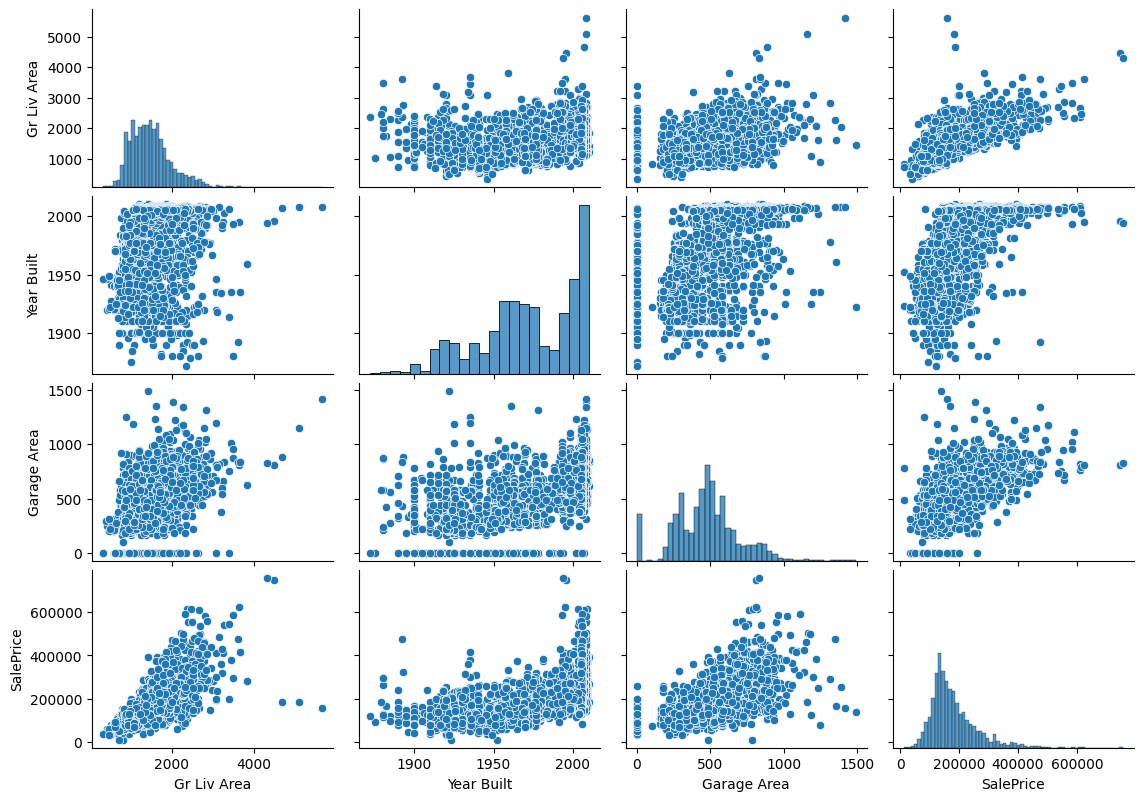

In [ ]:
# visualização exploratória de múltiplas variáveis

# Correctly select columns from the DataFrame
df_filtered = df[['Gr Liv Area', 'Year Built', 'Garage Area', 'SalePrice']]
figure = sns.pairplot(df_filtered)
figure.fig.set_size_inches(12,8)
plt.show() # Added plt.show() to display the plot

/usr/local/lib/python3.11/dist-packages/statsmodels/graphics/regressionplots.py:566: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  fig.tight_layout()
/tmp/ipython-input-17-2241480486.py:14: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  fig.tight_layout(pad=1.5)         # Margem entre subplots


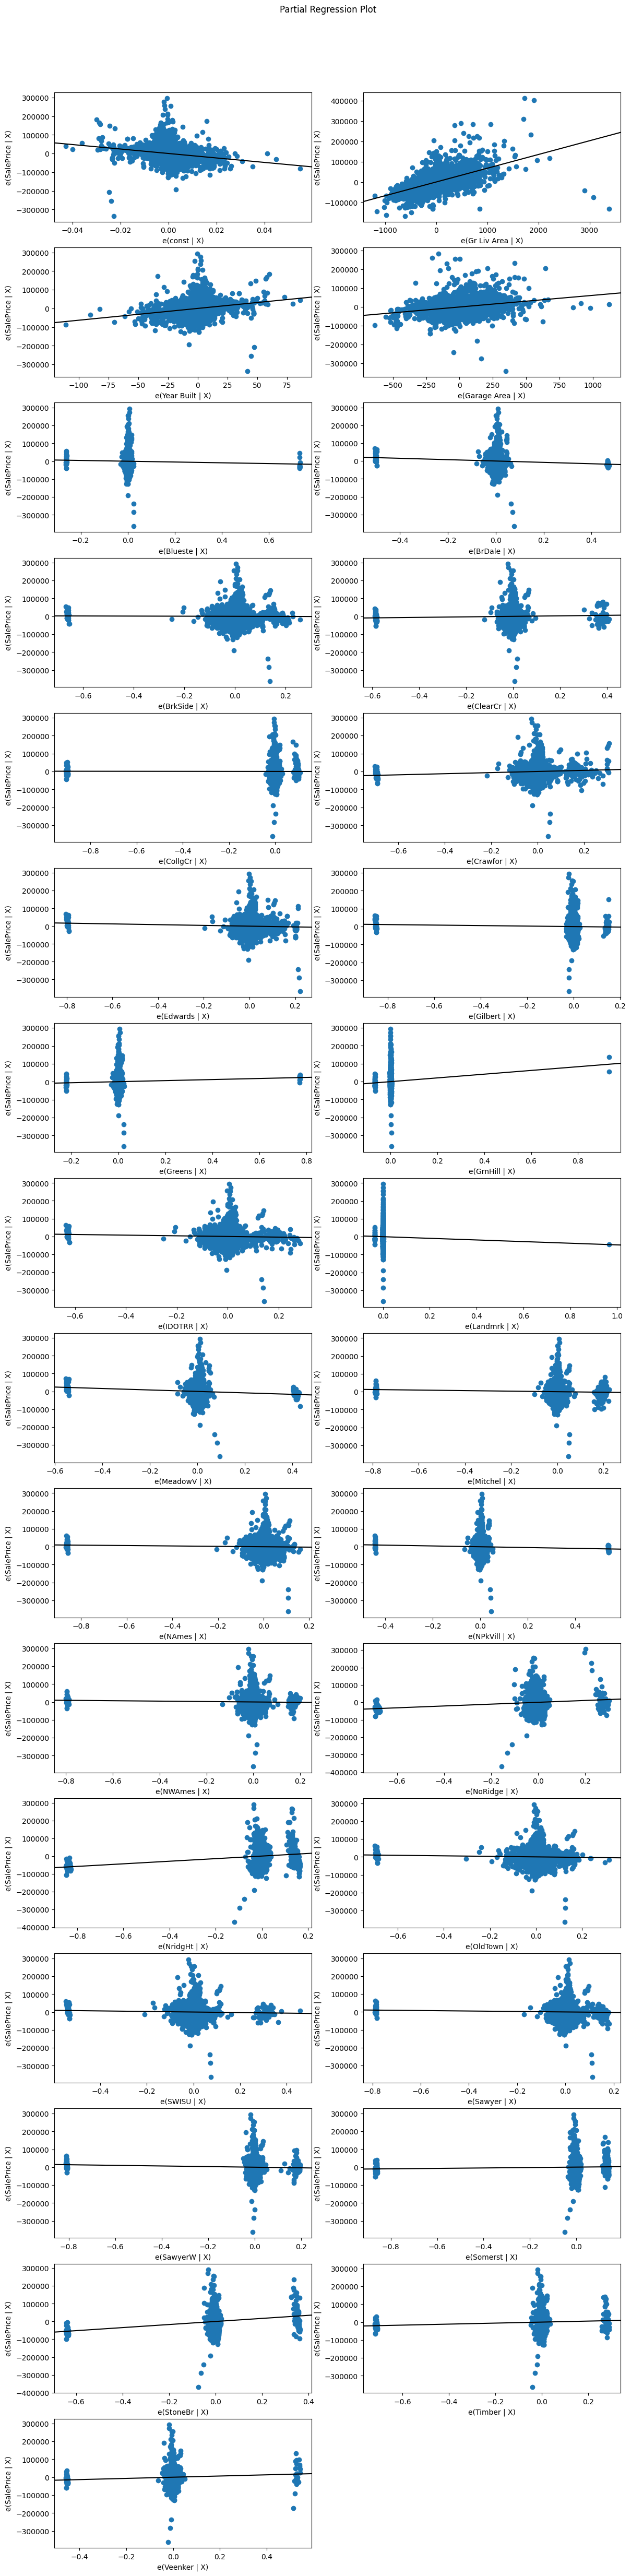

In [ ]:
# Gráfico para diagnosticar a relação entre cada variável explicativa e a variável alvo

# Número de variáveis explicativas no modelo
n_variaveis = len(modelo.model.exog_names)

# Calcular número de linhas com base em 2 colunas por linha
n_linhas = math.ceil(n_variaveis / 2)

# Altura estimada: 3.5 polegadas por linha (ajustável)
altura_total = 3.5 * n_linhas

# Gerar o gráfico
fig = sm.graphics.plot_partregress_grid(modelo)
fig.tight_layout(pad=1.5)         # Margem entre subplots
fig.set_size_inches(14, altura_total)  # Tamanho ajustado dinamicamente

,

**Os** gráficos de regressão parcial permitem visualizar o efeito isolado de cada variável preditora sobre a variável dependente (SalePrice), controlando pelos efeitos das demais variáveis no modelo. As variáveis Gr Liv Area, Garage Area e Year Built apresentam relações lineares bem definidas com o preço, como evidenciado pela inclinação positiva das retas ajustadas e pela dispersão relativamente estreita dos pontos ao redor dessas linhas. Isso confirma sua contribuição significativa e consistente para o modelo.

Em contrapartida, a maioria das variáveis dummies associadas aos bairros (Neighborhood) exibe nuvens de pontos bastante espalhadas, com padrões pouco definidos ou retas horizontais. Esse comportamento indica que essas variáveis ajudam a refinar o modelo, mas não possuem o mesmo peso explicativo que as variáveis numéricas.

Além disso, é possível notar que, em alguns gráficos, os resíduos se tornam mais dispersos para valores extremos, sugerindo uma leve heterocedasticidade — uma violação do pressuposto de variância constante dos erros. Essa condição não compromete a validade geral do modelo, mas sugere que técnicas complementares (como regressão robusta ou transformação logarítmica do preço) poderiam ser testadas para aprimorar a precisão da inferência estatística.

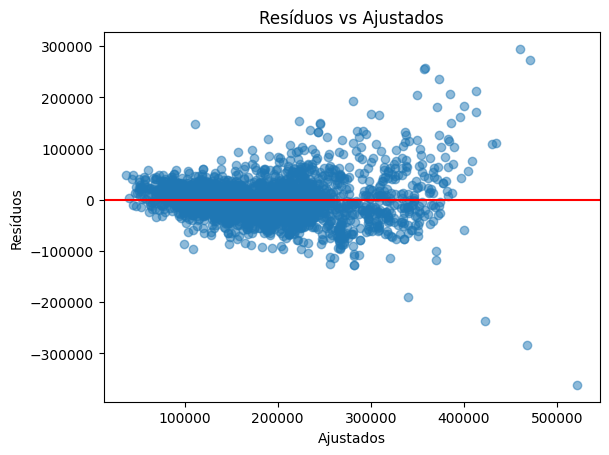

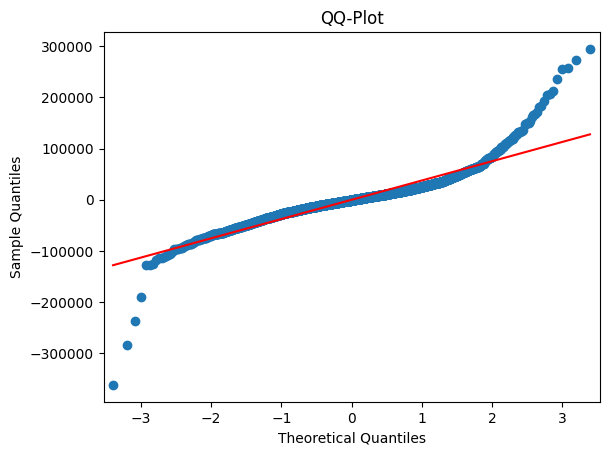

In [ ]:
# Resíduos vs Ajustados
residuos = modelo.resid
ajustado = modelo.fittedvalues

plt.scatter(ajustado, residuos, alpha=0.5)
plt.axhline(0, color='red')
plt.title("Resíduos vs Ajustados")
plt.xlabel("Ajustados")
plt.ylabel("Resíduos")
plt.show()

# QQ-Plot
sm.qqplot(residuos, line='s')
plt.title("QQ-Plot")
plt.show()


### Verificação dos Pressupostos de Normalidade e Homocedasticidade

#### 1. Resíduos vs Ajustados:

O gráfico de dispersão dos resíduos não apresenta um padrão totalmente aleatório, mas também **não evidencia fortemente o padrão de leque** observado anteriormente. Ainda assim, há sinais de que a variância dos resíduos **aumenta levemente para valores mais altos do preço ajustado**, o que pode indicar **heterocedasticidade moderada** — especialmente entre os imóveis mais caros.

#### 2. QQ-Plot:

O QQ-Plot mostra que os resíduos seguem razoavelmente a linha de normalidade no centro da distribuição, mas apresentam **desvios nas caudas** (tanto inferiores quanto superiores). Isso sugere que os resíduos **não são perfeitamente normais**, com possível influência de **outliers ou leve assimetria** na variável resposta.

### Conclusão sobre os pressupostos:

 O modelo apresenta **indícios moderados de violação dos pressupostos de normalidade e homocedasticidade**, o que **não invalida o modelo**, mas pode afetar a precisão da inferência estatística.

Recomenda-se considerar:
- Aplicar **transformação logarítmica** à variável `SalePrice` para estabilizar a variância;
- Utilizar modelos com **erros robustos** (`HC1`, `HC3`);
- Testar **regressão robusta** (como RLM do `statsmodels`) ou com **regularização** (Ridge ou Lasso).

In [ ]:
name = ['Multiplicador de Lagrange - Teste Breusch e Pagan de Heterocedasticidade ',
        'p-value', 'f-value', 'f: p-value']
test = sm.stats.het_breuschpagan(modelo.resid, modelo.model.exog)
lzip(name, test)

[('Multiplicador de Lagrange - Teste Breusch e Pagan de Heterocedasticidade ',
  np.float64(599.6597860618319)),
 ('p-value', np.float64(3.483902726178029e-107)),
 ('f-value', np.float64(24.868473478864093)),
 ('f: p-value', np.float64(3.65767530113108e-121))]

# **MODELO ROBUSTO**

In [25]:
# Definindo a variável dependente
y = df['SalePrice']

# Preparando a matriz de características com as variáveis independentes
# Concatenando as novas variáveis dummy com as variáveis independentes originais
x = pd.concat([df[['Gr Liv Area', 'Year Built', 'Garage Area']], dummies], axis=1)


# Ajustando o modelo OLS
modelo_robusto = sm.OLS(y, x, missing='drop').fit(cov_type='HC0')

# Fazendo previsões com o modelo ajustado
predictions = modelo_robusto.predict(x)
modelo_robusto.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 30, but rank is 29
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              SalePrice   R-squared (uncentered):                   0.962
Model:                            OLS   Adj. R-squared (uncentered):              0.962
Method:                 Least Squares   F-statistic:                              203.5
Date:                Mon, 14 Jul 2025   Prob (F-statistic):                        0.00
Time:                        22:50:29   Log-Likelihood:                         -35083.
No. Observations:                2929   AIC:                                  7.023e+04
Df Residuals:                    2899   BIC:                                  7.041e+04
Df Model:                          30                                                  
Covariance Type:                  HC0                                                  
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Gr Liv Area    66.3623      4.135     16.047      0.000      58.257      74.468
Year Built     37.3648      3.946      9.469      0.000      29.630      45.099
Garage Area    70.1136      5.674     12.358      0.000      58.993      81.234
Blueste     -4.147e+04   1.02e+04     -4.078      0.000   -6.14e+04   -2.15e+04
BrDale      -6.255e+04   5089.884    -12.289      0.000   -7.25e+04   -5.26e+04
BrkSide     -5.141e+04   5013.404    -10.255      0.000   -6.12e+04   -4.16e+04
ClearCr     -1.398e+04   8258.581     -1.692      0.091   -3.02e+04    2210.588
CollgCr     -1.204e+04   5008.325     -2.404      0.016   -2.19e+04   -2221.832
Crawfor     -8745.5402   6707.429     -1.304      0.192   -2.19e+04    4400.780
Edwards     -5.461e+04   5690.117     -9.598      0.000   -6.58e+04   -4.35e+04
Gilbert      -2.34e+04   5124.787     -4.567      0.000   -3.34e+04   -1.34e+04
Greens       8077.1066   6765.311      1.194      0.233   -5182.659    2.13e+04
GrnHill       9.18e+04   3.13e+04      2.929      0.003    3.04e+04    1.53e+05
IDOTRR      -6.919e+04   5381.830    -12.856      0.000   -7.97e+04   -5.86e+04
Landmrk       -5.9e+04   4619.840    -12.771      0.000   -6.81e+04   -4.99e+04
MeadowV      -6.46e+04   6002.746    -10.761      0.000   -7.64e+04   -5.28e+04
Mitchel     -3.509e+04   5705.896     -6.150      0.000   -4.63e+04   -2.39e+04
NAmes       -4.355e+04   4721.124     -9.225      0.000   -5.28e+04   -3.43e+04
NPkVill     -4.524e+04   5428.554     -8.333      0.000   -5.59e+04   -3.46e+04
NWAmes      -3.499e+04   5223.412     -6.698      0.000   -4.52e+04   -2.47e+04
NoRidge      4.058e+04   9718.355      4.175      0.000    2.15e+04    5.96e+04
NridgHt      6.574e+04   7656.878      8.585      0.000    5.07e+04    8.07e+04
OldTown      -6.87e+04   5000.715    -13.739      0.000   -7.85e+04   -5.89e+04
SWISU       -6.371e+04   6216.838    -10.247      0.000   -7.59e+04   -5.15e+04
Sawyer      -4.379e+04   4988.366     -8.778      0.000   -5.36e+04    -3.4e+04
SawyerW     -3.196e+04   5526.518     -5.784      0.000   -4.28e+04   -2.11e+04
Somerst      4810.6093   5709.452      0.843      0.399   -6379.711     1.6e+04
StoneBr       7.63e+04   1.26e+04      6.043      0.000    5.16e+04    1.01e+05
Timber       1.586e+04   7906.998      2.006      0.045     364.192    3.14e+04
Veenker      1.327e+04   1.42e+04      0.934      0.350   -1.46e+04    4.11e+04
==============================================================================
Omnibus:                      714.531   Durbin-Watson:                   1.692
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10883.185
Skew:                           0.735   Prob(JB):                         0.00
Kurtosis:                   

In [26]:
#modelo com ajuste de escala das vaiáveis

# Definindo a variável dependente em escala log, evitando valores zero ou negativos
y = np.log(df['SalePrice'] + 1)

# Aplicando log nas variáveis independentes contínuas, evitando valores zero ou negativos
x_continuas = np.log(df[['Gr Liv Area', 'Year Built', 'Garage Area']].replace(0, 1))

# Concatenando as variáveis independentes log-transformadas com as variáveis dummy
x = pd.concat([x_continuas, dummies], axis=1)

# Ajustando o modelo OLS sem a constante e com variância robusta (HC0)
modelo_robusto = sm.OLS(y, x, missing='drop').fit(cov_type='HC0')

# Fazendo previsões com o modelo ajustado
predictions = modelo_robusto.predict(x)

# Exibindo o resumo do modelo
print(modelo_robusto.summary())



                                 OLS Regression Results                                
Dep. Variable:              SalePrice   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                              1189.
Date:                Mon, 14 Jul 2025   Prob (F-statistic):                        0.00
Time:                        22:50:37   Log-Likelihood:                          692.49
No. Observations:                2929   AIC:                                     -1325.
Df Residuals:                    2899   BIC:                                     -1146.
Df Model:                          30                                                  
Covariance Type:                  HC0                                                  
                  coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 30, but rank is 29
  warnings.warn('covariance of constraints does not have full '


O modelo de regressão linear ajustado com erros robustos apresenta resultados consistentes com a versão anterior, confirmando a significância das variáveis Gr Liv Area, Year Built e Garage Area, além de diversos efeitos de bairro (`Neighborhood`). A utilização da robustez corrige os erros padrão sob heterocedasticidade, tornando os testes de hipóteses mais confiáveis.

Com R² mantido em 77,8%, o modelo mostra boa capacidade explicativa, e os coeficientes das principais variáveis se mantêm significativos e com interpretação econômica coerente. O uso de `HC0` é especialmente adequado, visto que os gráficos diagnósticos sugeriram leve violação da homocedasticidade.

Portanto, este modelo representa uma versão mais robusta e estatisticamente apropriada para fins de inferência.

.